In [1]:
%run circuit_dynamics_init.py # all needed functions 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format ='retina' #plot high-res img 
%load_ext line_profiler

### Possible parallel strategy: 

i) because the order dot product of different $U_n$ matrices with psi
is not relevant, we can generate $L/2$ #s of $U_n$ parallelly and send back to the master rank.
but we still have to apply the dot product sequentially in order to update the wavefunction 
in a recursive manner
        
ii) using a more low level approach by paralleling the kronecker product using MPI.
        
iii) Since we know the sparse matrix will be block diagonal 
with identical blocks, i.e., for each i, un = np.repeat\[blk, $2^{2*i}$ \],
where all blocks take the form $\textrm{blk}=\textrm{kron}(u, \textrm{identity_mat}(2^{(L-2i-2)}$)


it's easy to perform parallel dot operations by extracting different portions of 
the wavefunction and then join the vector back, 
i.e., new_vec = join(dot(blk, vec\[index with the length of blk\]))
        
Note: the sequential version of method (iii) doesn't work well
        
iv) The kronecker product between two matrices A and B can be obtained by 
the outer product of A_row with B_row, say, Outer\[$A_1, B_1$\] gives the first row of 
the resulting matrix. So we can compute the outer product in parallel 
(also calculate the corresponding dot product with the wavefunction at the same time)
and gather the resulting dot product, thus eliminating the need to compute the whole 
large sparse matrix.      

v) Simplest one: after evolving around $2 L$ time steps, the wavefunction reaches a steady state.
We can use the this wavefunction as an input to multiple nodes using MPI to gather 
enough data points (embarrassing parallel)

vi) By profiling the code we find the most time-consuming part of the code is for the unitary evolution. 

#### Import physical parameters and initialize wavefunction 

In [20]:
# reading parameters from file
para = open('para_haar.txt', 'r')
para = para.readlines()
# the paramters are system size, measurement probability and discrete time steps
L,  pro, time = int(para[0]), float(para[1]), int(para[2])

# system partition
# with PBC, we partition system into 4 parts where a and b separated by c1 and c2
# c1 and c2 are effectively connected, so the system is composed of A, B and C
lc1, la, lb = int(np.floor(L/8)), int(np.floor(L/4)), int(np.floor(L/4))
lc2 = L-lc1-la-lb
# pack the partition into array
part = np.array([L, la, lb, lc1, lc2], dtype="int64")

# initializing wavefunctions
p1 = np.ones(1)
p2 = np.zeros(2**L-1,dtype='c8')
# a product state with all spins align up
psi = np.concatenate((p1,p2),axis=0).T

In [21]:
# suitable for small size L<=18 
def evo(steps, wave, prob, k = 4, l = L, n = 2, partition = part):
    von = np.zeros(steps, dtype='float64') # von-Neumann entropy
    renyi = np.zeros(steps, dtype='float64') # Renyi entropy
    neg = np.zeros(steps, dtype='float64') # logarithmic negativity
    mut = np.zeros(steps, dtype='float64') # mutual information using von-Neumann entropy
    mutr = np.zeros(steps, dtype='float64') # mutual information in terms of Renyi entropy
    
    for t in range(steps):
        # evolve over All links
        wave = unitary(wave, k, l)   
        
        # measurement layer
        '''
        with this protocol, we need to double the measurement rate
        '''
        for j in range(l):
            wave = measure(wave, prob, j, l)
       
        result = ent(wave, n, l//2, l) # half-chain entanglement entropy
        von[t] = result[0]
        renyi[t] = result[1]
        result = logneg(wave, n, partition)
        neg[t] = result[0]
        mut[t] = result[1]
        mutr[t] = result[2]

    return np.array([von, renyi, neg , mut, mutr])

In [22]:
# pure python version with original evolution scheme
def evo_original(steps, wave, prob, l = L, n = 2, partition = part):
    von = np.zeros(steps, dtype='float64') # von-Neumann entropy
    renyi = np.zeros(steps, dtype='float64') # Renyi entropy
    neg = np.zeros(steps, dtype='float64') # logarithmic negativity
    mut = np.zeros(steps, dtype='float64') # mutual information using von-Neumann entropy
    mutr = np.zeros(steps, dtype='float64') # mutual information in terms of Renyi entropy
    
    for t in range(steps):
        # evolve over odd links
        for i in range(l//2):
            wave = unitary_conventional(wave, i, l)     
        
        # measurement layer
        for i in range(l):
            wave = measure(wave, prob, i, l)

        # before evolve on even link, we need to rearrange indices first to accommodate the boundary condition PBC
        wave = np.reshape(wave,(2, 2**(l-2),2))
        # move the last site into the first one such that the unitaries can connect the 1st and the last site
        wave = np.moveaxis(wave,-1,0)
        wave = wave.flatten()
        
        # evolve over even links
        for i in range(l//2):
            wave = unitary_conventional(wave, i, l)  

        #shift the index back to the original order after evolution
        wave = np.reshape(wave,(2, 2, 2**(l-2)))
        wave = np.moveaxis(wave,-1,0)
        wave = np.moveaxis(wave,-1,0).flatten()

        #measurement layer
        for i in range(l):
            wave = measure(wave, prob, i, l)
       
        result = ent(wave, n, l//2, l)
        von[t] = result[0]
        renyi[t] = result[1]
        result = logneg(wave, n, partition)
        neg[t] = result[0]
        mut[t] = result[1]
        mutr[t] = result[2]

    return np.array([von, renyi, neg , mut, mutr])

In [23]:
%lprun -f evo res = evo(time, psi, 2*pro)

Timer unit: 1e-06 s

Total time: 16.4368 s
File: <ipython-input-21-d9fc29cfa274>
Function: evo at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           def evo(steps, wave, prob, k = 4, l = L, n = 2, partition = part):
     3         1         15.0     15.0      0.0      von = np.zeros(steps, dtype='float64') # von-Neumann entropy
     4         1          5.0      5.0      0.0      renyi = np.zeros(steps, dtype='float64') # Renyi entropy
     5         1          3.0      3.0      0.0      neg = np.zeros(steps, dtype='float64') # logarithmic negativity
     6         1          3.0      3.0      0.0      mut = np.zeros(steps, dtype='float64') # mutual information using von-Neumann entropy
     7         1          3.0      3.0      0.0      mutr = np.zeros(steps, dtype='float64') # mutual information in terms of Renyi entropy
     8                                               
     9        61         38.0      0.6   

In [24]:
%lprun -f evo_original res2 = evo_original(time, psi, pro)

Timer unit: 1e-06 s

Total time: 34.3239 s
File: <ipython-input-22-c7c45f7cf85b>
Function: evo_original at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           def evo_original(steps, wave, prob, l = L, n = 2, partition = part):
     3         1         10.0     10.0      0.0      von = np.zeros(steps, dtype='float64') # von-Neumann entropy
     4         1          2.0      2.0      0.0      renyi = np.zeros(steps, dtype='float64') # Renyi entropy
     5         1          2.0      2.0      0.0      neg = np.zeros(steps, dtype='float64') # logarithmic negativity
     6         1          2.0      2.0      0.0      mut = np.zeros(steps, dtype='float64') # mutual information using von-Neumann entropy
     7         1          2.0      2.0      0.0      mutr = np.zeros(steps, dtype='float64') # mutual information in terms of Renyi entropy
     8                                               
     9        61         46.0 

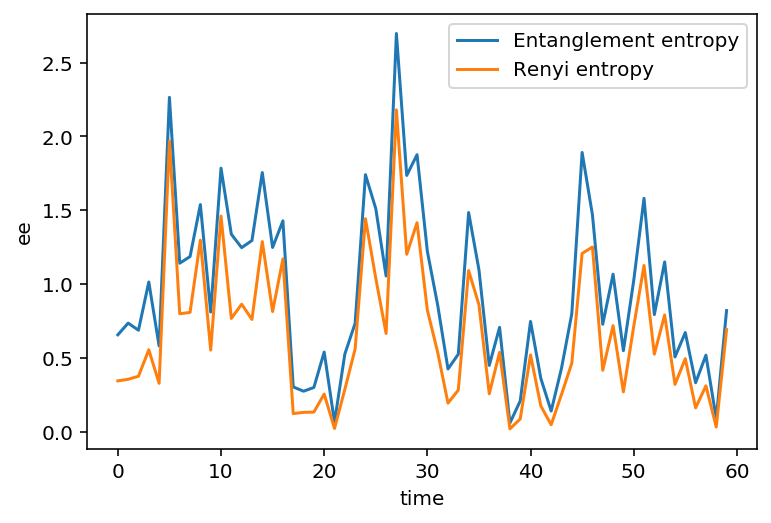

In [25]:
import matplotlib.ticker as mticker
plt.plot(res[0], label='Entanglement entropy')
plt.plot(res[1], label='Renyi entropy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(10))
plt.legend()
plt.ylabel('ee')
plt.xlabel('time')
plt.show()

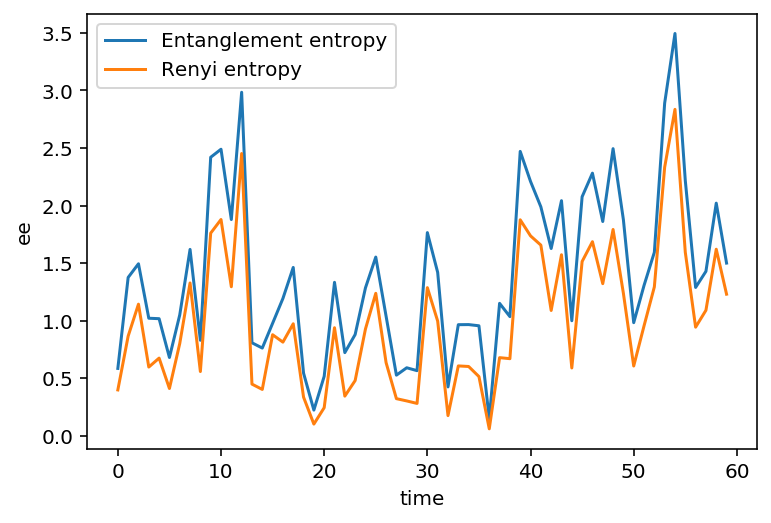

In [26]:
plt.plot(res2[0], label='Entanglement entropy')
plt.plot(res2[1], label='Renyi entropy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(10))
plt.legend()
plt.ylabel('ee')
plt.xlabel('time')
plt.show()

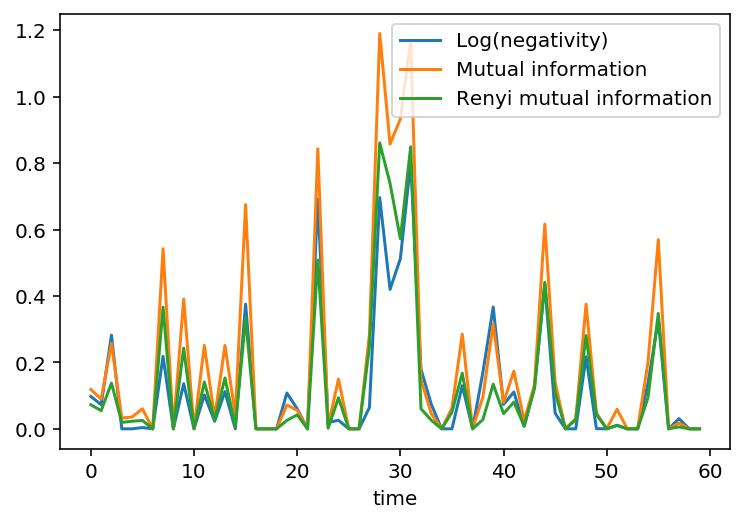

In [27]:
plt.plot(res[2], label='Log(negativity)')
plt.plot(res[3], label='Mutual information')
plt.plot(res[4], label='Renyi mutual information')
#plt.ylabel('log(negativity)')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(10))
plt.xlabel('time')
plt.legend()
plt.show()

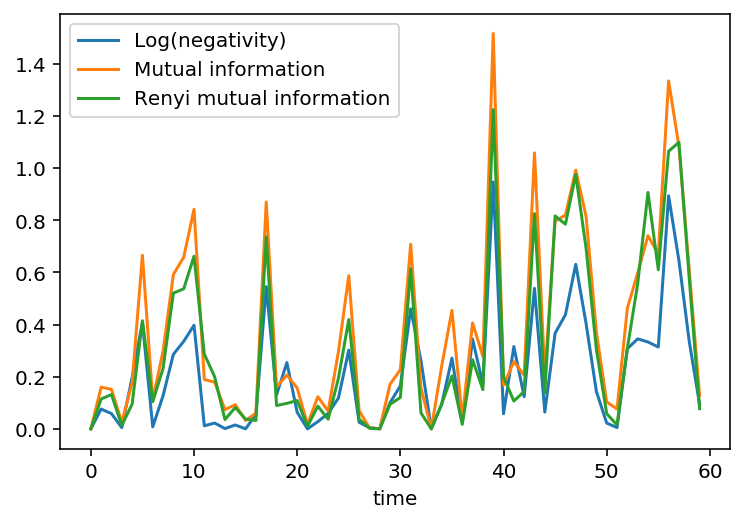

In [28]:
plt.plot(res2[2], label='Log(negativity)')
plt.plot(res2[3], label='Mutual information')
plt.plot(res2[4], label='Renyi mutual information')
#plt.ylabel('log(negativity)')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(10))
plt.xlabel('time')
plt.legend()
plt.show()